In [22]:
import torch
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error

from torch.autograd import Variable
import random

import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset, DataLoader

In [23]:
print('GPU availability:', torch.cuda.is_available())

GPU availability: True


In [24]:
class prediction_model(nn.Module):

    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super(prediction_model, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden1_size)
        # self.dropout1 = nn.Dropout(p=0.1)
        self.batch1 = nn.BatchNorm1d(hidden1_size)

        self.hidden2 = nn.Linear(hidden1_size, hidden2_size)
        # self.dropout2 = nn.Dropout(p=0.01)
        self.batch2 = nn.BatchNorm1d(hidden2_size)

        # self.hidden3 = nn.Linear(hidden2_size, hidden3_size)
        # self.batch3 = nn.BatchNorm1d(hidden3_size)

        self.predict = nn.Linear(hidden2_size, output_size)
    
    def forward(self, input):
        result = self.hidden1(input)
        # result = self.dropout1(result)
        result = self.batch1(result)
        result = F.leaky_relu(result)

        result = self.hidden2(result)
        # result = self.dropout2(result)
        result = self.batch2(result)
        result = F.leaky_relu(result)

        # result = self.hidden3(result)
        # result = self.batch3(result)
        # result = F.leaky_relu(result)

        result = self.predict(result)

        return result

In [25]:
def train(model, x_data, y_data, optimizer, loss, epochs, device):

    final_R2_train = []
    final_R2_test = []
    final_rmse_train = []
    final_rmse_test = []
    
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 64)

    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1) # convert 1D to 2D, from (N,) to (N,1)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
    test_load = DataLoader(test_dataset, batch_size = 64, shuffle = True)


    for epoch in range(epochs):
        model.train()

        mse_loss = []
        # define batch: batch_sizee = 100
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()   # initialize gradient, gradient computed from batch 1 does not interfere batch2 and model update

            output = model(batch_x)
            l = loss(output, batch_y)

            mse_loss.append(l.item())   # l.item() 返回tensor中的每一个值，节约内存

            l.backward()     # back propagation
            optimizer.step()    # update model
        
        
        if epoch % 5 == 0:
            with torch.no_grad():
                model.eval()
                train_pred = model(x_train_tensor.to(device)).cpu().numpy().flatten()
                r2_train = r2_score(y_train, train_pred)
                rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))

                final_R2_train.append(r2_train)
                final_rmse_train.append(rmse_train)

                # final_R2_test.append()
                print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {np.mean(mse_loss)}, R2 Score (Train): {r2_train}, RMSE (Train): {rmse_train}")

                test_loss = []
                test_preds_list = []
                test_target_list = []
                for batch_x, batch_y in test_load:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    test_output = model(batch_x)
                    l = loss(test_output, batch_y)
                    test_loss.append(l.item())

                    test_preds_list.append(test_output.cpu().numpy())
                    test_target_list.append(batch_y.cpu().numpy())
                    
                test_preds = np.concatenate(test_preds_list).flatten()
                test_target = np.concatenate(test_target_list).flatten()

                r2_test = r2_score(test_target, test_preds)
                rmse_test = np.sqrt(mean_squared_error(test_target, test_preds))

                final_R2_test.append(r2_test)
                final_rmse_test.append(rmse_test)

                print(f"Test Loss: {np.mean(test_loss)}, R2 Score (Test): {r2_test}, RMSE (Test): {rmse_test}")

    return final_R2_test, final_R2_train, final_rmse_test, final_rmse_train

In [26]:
x_data = pd.read_csv('./data/x_value_train_with_ALogP.csv')
x_data = x_data.values
x_data

array([[0.  , 1.  , 0.  , ..., 0.  , 0.  , 3.22],
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 3.56],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 2.46],
       ...,
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 2.68],
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 2.32],
       [0.  , 1.  , 0.  , ..., 0.  , 0.  , 2.32]])

In [27]:
y_data = pd.read_csv('./data/y_value_train_with_ALogP.csv')
y_data = y_data.values
# y_data

In [28]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device', device)
model = prediction_model(x_data.shape[1], 512, 256, 1)
loss_func = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-5)

model = model.to(device)
loss = loss_func.to(device)
epochs = 5000

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 64)


final_R2_test, final_R2_train, final_rmse_test, final_rmse_train = train(model, x_data, y_data, optimizer, loss, epochs, device)

# for plot
final_R2_train = final_R2_train[5:]
final_R2_test = final_R2_test[5:]
final_rmse_train = final_rmse_train[5:]
final_rmse_test = final_rmse_test[5:]

# for calculation
print('=========================================')
final_R2_train_sub = final_R2_train[200:]
final_R2_test_sub = final_R2_test[200:]
final_rmse_train_sub = final_rmse_train[200:]
final_rmse_test_sub = final_rmse_test[200:]
print(f'average R2 on training dataset:{np.mean(final_R2_train_sub)}, average R2 on testing dataset:{np.mean(final_R2_test_sub)}')
print(f'average rmse on training dataset:{np.mean(final_rmse_train_sub)}, average rmse on testing dataset:{np.mean(final_rmse_test_sub)}')

Using device cuda
Epoch [1/5000], Train Loss: 47.70114008585612, R2 Score (Train): -16.037393177334916, RMSE (Train): 6.933115952804351
Test Loss: 45.754600524902344, R2 Score (Test): -17.43677610507256, RMSE (Test): 6.7350921630859375
Epoch [6/5000], Train Loss: 33.52093760172526, R2 Score (Train): -10.247355194568785, RMSE (Train): 5.633160118600557
Test Loss: 32.73237991333008, R2 Score (Test): -12.297561361974212, RMSE (Test): 5.719881534576416
Epoch [11/5000], Train Loss: 25.673515637715656, R2 Score (Train): -7.41373217929725, RMSE (Train): 4.8721565289276825
Test Loss: 25.436023712158203, R2 Score (Test): -9.338565923703461, RMSE (Test): 5.043490409851074
Epoch [16/5000], Train Loss: 19.4802143573761, R2 Score (Train): -5.359817592097046, RMSE (Train): 4.235934348864079
Test Loss: 20.32651138305664, R2 Score (Test): -7.1910759785909395, RMSE (Test): 4.489226818084717
Epoch [21/5000], Train Loss: 14.72818374633789, R2 Score (Train): -3.7835761283878417, RMSE (Train): 3.6736961713

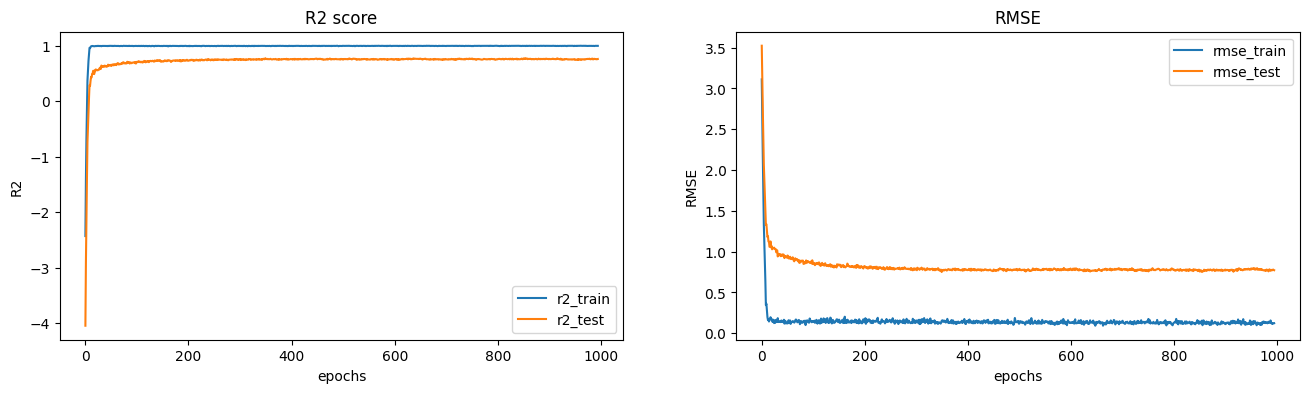

In [29]:
x = [i for i in range(995)]
fig = plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(x, final_R2_train, label = 'r2_train')
plt.plot(x, final_R2_test, label = 'r2_test')
plt.legend()
plt.title('R2 score')
plt.xlabel('epochs')
plt.ylabel('R2')

plt.subplot(1, 2, 2)
plt.plot(x, final_rmse_train, label = 'rmse_train')
plt.plot(x, final_rmse_test, label = 'rmse_test')
plt.legend()
plt.title('RMSE')
plt.xlabel('epochs')
plt.ylabel('RMSE')

plt.show()

In [31]:
# torch.save(model, 'ANN_model_with_ALogP.pth')